In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions

In [18]:
# -----------------------------
# 1. Load & preprocess MNIST
# -----------------------------
(x_train, _), _ = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0        # [0, 1]
x_train = x_train.reshape(-1, 28 * 28)             # (N, 784)

batch_size = 256
data_dim = 28 * 28

train_ds = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(10000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


In [19]:
# -------------------------------------------------
# 2. Affine coupling network (Keras-only)
#    (Adapted from keras.io RealNVP example)
# -------------------------------------------------
output_dim = 512
reg = 1e-4

def Coupling(input_dim):
    """Return a Keras Model that outputs (s, t) given x_masked."""
    inp = keras.Input(shape=(input_dim,))

    # Translation network t(x_masked)
    t = layers.Dense(output_dim, activation="relu",
                     kernel_regularizer=regularizers.l2(reg))(inp)
    t = layers.Dense(output_dim, activation="relu",
                     kernel_regularizer=regularizers.l2(reg))(t)
    t = layers.Dense(output_dim, activation="relu",
                     kernel_regularizer=regularizers.l2(reg))(t)
    t = layers.Dense(input_dim, activation="linear",
                     kernel_regularizer=regularizers.l2(reg))(t)

    # Scale network s(x_masked)
    s = layers.Dense(output_dim, activation="relu",
                     kernel_regularizer=regularizers.l2(reg))(inp)
    s = layers.Dense(output_dim, activation="relu",
                     kernel_regularizer=regularizers.l2(reg))(s)
    s = layers.Dense(output_dim, activation="relu",
                     kernel_regularizer=regularizers.l2(reg))(s)
    s = layers.Dense(input_dim, activation="tanh",
                     kernel_regularizer=regularizers.l2(reg))(s)

    return keras.Model(inp, [s, t])

In [20]:
# -------------------------------------------------
# 3. RealNVP model as a Keras.Model
#    (same structure as keras.io example, generalized to 784-D)
# -------------------------------------------------
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers, data_dim):
        super().__init__()
        self.num_coupling_layers = num_coupling_layers
        self.data_dim = data_dim

        # Base distribution in latent space z
        self.distribution = tfd.MultivariateNormalDiag(
            loc=tf.zeros(data_dim),
            scale_diag=tf.ones(data_dim)
        )

        # Create alternating binary masks (0/1) over 784 dims
        mask0 = np.array([i % 2 for i in range(data_dim)], dtype="float32")
        mask1 = 1.0 - mask0
        masks = []
        for i in range(num_coupling_layers):
            masks.append(mask0 if i % 2 == 0 else mask1)
        self.masks = tf.constant(np.stack(masks, axis=0))  # (L, D)

        # Track loss as a metric
        self.loss_tracker = keras.metrics.Mean(name="loss")

        # One coupling network per layer
        self.layers_list = [Coupling(data_dim) for _ in range(num_coupling_layers)]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        """
        Forward pass.

        training=True  -> data -> latent (inverse flow in RealNVP paper)
        training=False -> latent -> data (sampling)
        """
        log_det_inv = 0.0
        direction = -1 if training else 1

        if direction == -1:
            layer_iter = range(self.num_coupling_layers - 1, -1, -1)
        else:
            layer_iter = range(self.num_coupling_layers)

        for i in layer_iter:
            mask = self.masks[i]                 # (D,)
            x_masked = x * mask
            reversed_mask = 1.0 - mask

            s, t = self.layers_list[i](x_masked)  # each (B, D)
            s = s * reversed_mask
            t = t * reversed_mask

            gate = (direction - 1.0) / 2.0
            # RealNVP affine coupling transform
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )

            log_det_inv += gate * tf.reduce_sum(s, axis=1)

        return x, log_det_inv

    def log_loss(self, x):
        # map x -> z  (training=True)
        y, logdet = self(x, training=True)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            loss = self.log_loss(x)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def sample(self, num_samples):
        """Draw samples in data space."""
        z = self.distribution.sample(num_samples)      # latent samples
        x, _ = self(z, training=False)                 # invert the flow
        return tf.clip_by_value(x, 0.0, 1.0)


In [24]:
# -----------------------------
# 4. Training
# -----------------------------
model = RealNVP(num_coupling_layers=4, data_dim=data_dim)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

print("Number of trainable variables:", len(model.trainable_variables))
# You should see a non-zero number here (dozens).

model.fit(train_ds, epochs=20)   # bump epochs if you want better samples


Number of trainable variables: 64
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: -277.8030
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: -530.6246
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: -573.7795
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: -600.6259
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: -620.9796
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: -637.4531
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: -651.1121
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: -663.0685
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: -672.9597
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: -680.5214
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - loss: -688.2615
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - loss: -694.8530
Epoch 13/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: -700.7762
Epoch 14/20
235/235 ━━━━━━

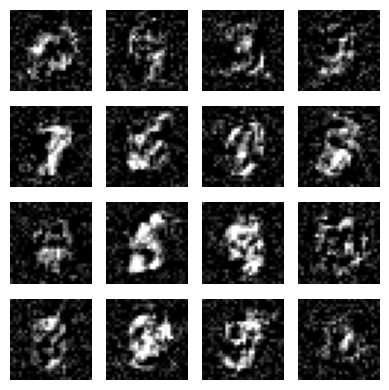

In [25]:
# -----------------------------
# 5. Sampling new "digits"
# -----------------------------
num_samples = 16
samples = model.sample(num_samples)                # (N, 784)
samples_img = tf.reshape(samples, (-1, 28, 28))

plt.figure(figsize=(4, 4))
for i in range(num_samples):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples_img[i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()